In [1]:
# default_exp lowess

# Lowess

[![Binder](https://notebooks.gesis.org/binder/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/AyrtonB/Merit-Order-Effect/main?filepath=nbs%2Fdev-03-lowess.ipynb)

Outlines the development of the Scikit-Learn compatible `Lowess` model, as well as its extension `LowessDates` used for time-adaptive LOWESS regression. Included are functions for extending both models to generate prediction and confidence intervals. 

The original LOWESS code written by W. S. Cleveland can be found [here](https://www.netlib.org/go/lowess)

<br>

### Imports

In [2]:
#exports
import pandas as pd
import numpy as np

from collections.abc import Iterable
from sklearn import linear_model

from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from scipy import linalg

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from timeit import timeit
from ipypb import track

from moepy import eda

<br>

### LOWESS Development

Before we go ahead any further we'll create some sample data for fitting and also define the fraction of the data over which we'll do the localised regression.

In [3]:
x = np.linspace(0, 5, num=26)
y = np.sin(x)

frac = 0.5

<br>

We can see that we've just created a simple sin curve

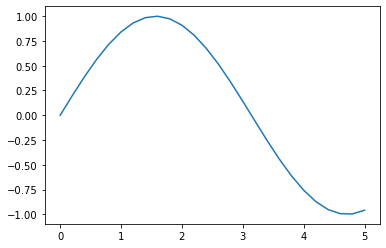

In [4]:
plt.plot(x, y)

<br>

#### Weights

In order to do localised regression we need to know what points are local, for this reason we'll start by creating a function for calculating the distance between one point and all of the other points

In [5]:
#exports
get_dist = lambda X, x: np.abs(X - x)

In [6]:
dist = get_dist(x, x[0])

dist

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

<br>

We've defined our selection of local based on the fraction of surrounding data, this means we need to calculate the distance around any given point that contains the fraction of data specified

In [7]:
#exports
def get_dist_threshold(dist, frac=0.4):
    """Identifies the minimum distance that contains the desired data fraction"""
    frac_idx = int(np.ceil(len(dist)*frac))
    dist_threshold = sorted(dist)[frac_idx]
    
    return dist_threshold

In [8]:
dist_threshold = get_dist_threshold(dist, frac=frac)

dist_threshold

2.6

<br>
We'll now define a function that will map from the distances to their relative weights according to a tricube kernel

$$
\begin{equation}
  \label{eqn:tricube_kernel}
    w(x) = \left\{ 
    \begin{array}{ll}
    (1 - |x|^3)^3 & \mbox{for $|x| < 1$}    \\
    0             & \mbox{for $|x| \geq 1$}
    \end{array}
    \right.
\end{equation}
$$

In [9]:
#exports
dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3

(0.0, 1.1)

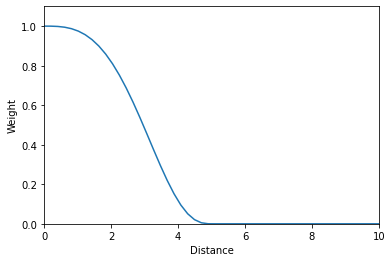

In [10]:
dist_threshold = 5
dist_sample = np.linspace(0, 10)

weights_sample = dist_to_weights(dist_sample, dist_threshold)

# Plotting
plt.plot(dist_sample, weights_sample)

plt.xlabel('Distance')
plt.ylabel('Weight')
plt.xlim(0, max(dist_sample))
plt.ylim(0, 1.1)

<br>

We can now use the distance matrix and threshold to create a vector of the relative weights of all data points for the local regression at a specified location

In [11]:
weights = dist_to_weights(dist, dist_threshold)

weights

array([1.        , 0.99980801, 0.99846479, 0.99482495, 0.98776226,
       0.97619149, 0.95909867, 0.93557909, 0.90488204, 0.86646079,
       0.82002586, 0.76559882, 0.70356317, 0.63470792, 0.56025877,
       0.4818903 , 0.40171203, 0.32221935, 0.24619951, 0.17658114,
       0.11621427, 0.06756635, 0.03231788, 0.01083964, 0.00153137,
       0.        ])

<br>

We'll wrap these steps into a single function and see how long it takes to compute

In [12]:
def get_weights(x, loc, frac=0.4):
    """Calculates the weightings at each data point for a single localised regression"""
    dist = get_dist(x, loc)
    dist_threshold = get_dist_threshold(dist, frac=frac)

    weights = dist_to_weights(dist, dist_threshold)
    
    return weights

In [13]:
timeit(lambda: get_weights(x, x[5]), number=10000)

0.6126709999999989

<br>

We've successfully calculated the weights with respect to a single point but we need to repeat this across each of value locations in our dataset.

In [14]:
#exports
def get_all_weights(x, frac=0.4):
    """Calculates the weightings at each data point for a LOWESS regression"""
    all_weights = []

    for i in range(len(x)):
        weights = get_weights(x, x[i], frac=frac)
        all_weights += [weights]

    all_weights = np.array(all_weights)
    
    return all_weights

In [15]:
all_weights = get_all_weights(x, frac=frac)

all_weights[:5, :5]

array([[1.        , 0.99863512, 0.98911574, 0.96358278, 0.91512916],
       [0.99826489, 1.        , 0.99826489, 0.98617531, 0.95385361],
       [0.98207661, 0.99774775, 1.        , 0.99774775, 0.98207661],
       [0.92116732, 0.97619149, 0.997003  , 1.        , 0.997003  ],
       [0.75907091, 0.89295331, 0.96743815, 0.99589042, 1.        ]])

<br>

Not too bad at all, we could now use this to weight the fitting of the polynomials in the LOWESS. However, we've carried out most of these operations as part of for loops over vectors, what if we could store our data in matrices and do single operations over them?

Thankfully Numpy has lots of helpful functions to aid us in this. We'll start by creating a matrix with the distances, to do this we can reshape the vectors into matrices of shape (25, 1) and (1, 25), then deduct the matrix with only one row from the matrix with only one column.

In [16]:
#exports
vector_to_dist_matrix = lambda x: np.abs(x.reshape(-1, 1) - x.reshape(1, -1))

Text(69.58333333333334, 0.5, 'Regression Nodes')

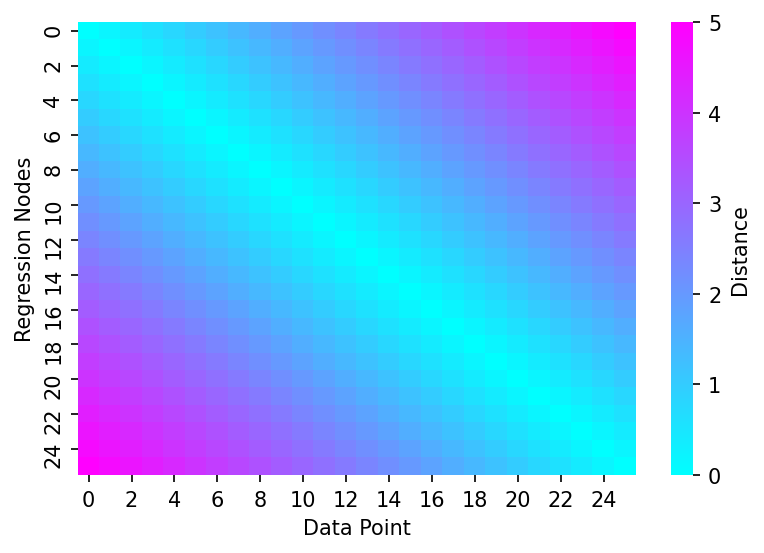

In [17]:
dist_matrix = vector_to_dist_matrix(x)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(dist_matrix, cmap='cool', cbar_kws={'label':'Distance'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

This approach brings an order of magnitude speed-up to the operation

In [18]:
%%timeit

timeit(lambda: [get_dist(x, x[x_idx]) for x_idx in range(len(x))], number=10000)

825 ms ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit

timeit(lambda: vector_to_dist_matrix(x), number=10000)

55.5 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<br>

Now we need to calculate the distance threshold (max distance away from point of interest that is within the data fraction specified). 

<a href="https://gist.github.com/agramfort/850437">Alexandre Gramfort</a> lays out one approach to determine the distances using a list comprehension.

In [20]:
#exports
get_frac_idx = lambda x, frac: int(np.ceil(len(x) * frac)) - 1

In [21]:
gramfort_get_dist_thresholds = lambda x, frac_idx: [np.sort(np.abs(x - x[i]))[frac_idx] for i in range(len(x))]

frac_idx = get_frac_idx(x, frac)

timeit(lambda: gramfort_get_dist_thresholds(x, frac_idx), number=10000)

1.7785535999999986

<br>

Pretty quick, lets see if we could do better though. 

We'll try keeping the distance matrix intact rather than breaking it up in each iteration. This enables us to do the absolute conversion, sorting and indexing over a matrix rather than looping the operations over vectors. 

These changes gave us an order of magnitude speed-up.

In [22]:
#exports
get_dist_thresholds = lambda x, frac_idx, dist_matrix: np.sort(dist_matrix)[:, frac_idx]

In [23]:
dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)

timeit(lambda: get_dist_thresholds(x, frac_idx, dist_matrix), number=10000)

0.10906620000000089

<br>

Now we have both the distance matrix and thresholds we can start to calculate the weightings, the first step to this is scale and clip the distances based on their threshold values.

In [24]:
inv_linear_weights = np.clip(dist_matrix/dist_thresholds.reshape(-1, 1), 0, 1)

inv_linear_weights[:5, :5]

array([[0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333],
       [0.09090909, 0.        , 0.09090909, 0.18181818, 0.27272727],
       [0.2       , 0.1       , 0.        , 0.1       , 0.2       ],
       [0.33333333, 0.22222222, 0.11111111, 0.        , 0.11111111],
       [0.5       , 0.375     , 0.25      , 0.125     , 0.        ]])

<br>

We can now calculate the tri-cubic weighting. We repeat this using both base Python and Numpy to see which is faster, surprisingly base Python comes out on top.

In [25]:
timeit(lambda: (1 - inv_linear_weights ** 3) ** 3, number=10000)

0.4310475999999994

In [26]:
timeit(lambda: np.power(1 - np.power(inv_linear_weights, 3), 3), number=10000)

0.44873660000000015

<br>

After a little more exploration it appears that Numpy's <i>power</i> function only offers improvements over base Python when the exponent is very high. For a good discussion on why this is the case you can read more <a href="">here</a>.

In [27]:
timeit(lambda: (1 - inv_linear_weights ** 50000) ** 50000, number=10000)

0.5387637000000005

In [28]:
timeit(lambda: np.power(1 - np.power(inv_linear_weights, 50000), 50000), number=10000)

0.526861499999999

<br>

We'll now wrap these two steps up into a single function

In [29]:
#exports
def clean_weights(weights):
    """Normalises each models weightings and removes non-finite values"""
    with np.errstate(divide='ignore', invalid='ignore'):
        weights = weights/weights.sum(axis=0) # We'll then normalise the weights so that for each model they sum to 1 for a single data point
    
    weights = np.where(~np.isfinite(weights), 0, weights) # And remove any non-finite values
    
    return weights

def dist_2_weights_matrix(dist_matrix, dist_thresholds):
    """Converts distance matrix and thresholds to weightings"""
    weights = dist_to_weights(dist_matrix, dist_thresholds.reshape(-1, 1))
    weights = clean_weights(weights)
    
    return weights

In [30]:
weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)

weights[:5, :5]

array([[0.20861363, 0.18398963, 0.16064453, 0.13720751, 0.11473407],
       [0.20814378, 0.18430943, 0.16252964, 0.14126726, 0.12082652],
       [0.20364685, 0.18375705, 0.16289653, 0.14341436, 0.1254292 ],
       [0.18628223, 0.17830797, 0.16222709, 0.14384546, 0.12796029],
       [0.13975483, 0.15666172, 0.15537944, 0.14300426, 0.12848832]])

<br>

And then combine them with the creation of the distance matrix and threshold

In [31]:
#exports
def get_full_dataset_weights_matrix(x, frac=0.4):
    """Wrapper for calculating weights from the raw data and LOWESS fraction"""
    frac_idx = get_frac_idx(x, frac)
    
    dist_matrix = vector_to_dist_matrix(x)
    dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)
    
    weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)
    
    return weights

In [32]:
weights = get_full_dataset_weights_matrix(x, frac)

<br>

We'll do a quick visual check to see if they look reasonable

In [33]:
weights[:5, :5]

array([[0.20861363, 0.18398963, 0.16064453, 0.13720751, 0.11473407],
       [0.20814378, 0.18430943, 0.16252964, 0.14126726, 0.12082652],
       [0.20364685, 0.18375705, 0.16289653, 0.14341436, 0.1254292 ],
       [0.18628223, 0.17830797, 0.16222709, 0.14384546, 0.12796029],
       [0.13975483, 0.15666172, 0.15537944, 0.14300426, 0.12848832]])

<br>

Looks good, we'll also time it

In [34]:
timeit(lambda: get_full_dataset_weights_matrix(x, frac=frac), number=10000)

1.4529582999999988

<br>

Currently we have created a weights matrix that scales in size as the square of the dataset length, this could quickly become prohibitively computationally expensive for large datasets.

Instead we'll create a new function that lets us either specify a vector of locations (`reg_anchors`) where the regressions will be centered, or alternatively if `num_fits` is passed that will be the number of local regressions.

In [35]:
#exports
num_fits_2_reg_anchors = lambda x, num_fits: np.linspace(x.min(), x.max(), num=num_fits)

def get_weighting_locs(x, reg_anchors=None, num_fits=None): 
    """Identifies the weighting locations for the provided dataset"""
    num_type_2_dist_rows = {
        type(None) : lambda x, num_fits: x.reshape(-1, 1),
        int : lambda x, num_fits: num_fits_2_reg_anchors(x, num_fits).reshape(-1, 1),
    }
    
    if reg_anchors is None:
        weighting_locs = num_type_2_dist_rows[type(num_fits)](x, num_fits)
    else:
        weighting_locs = reg_anchors.reshape(-1, 1)
        
    return weighting_locs

def create_dist_matrix(x, reg_anchors=None, num_fits=None): 
    """Constructs the distance matrix for the desired weighting locations"""
    weighting_locs = get_weighting_locs(x, reg_anchors=reg_anchors, num_fits=num_fits)
    dist_matrix = np.abs(weighting_locs - x.reshape(1, -1))
    
    return dist_matrix

In [36]:
dist_matrix = create_dist_matrix(x)

dist_matrix.shape

(26, 26)

<br>

When neither `reg_anchors` nor `num_fits` are passed it defaults to using all data-points in the matrix which can be seen below

Text(69.58333333333334, 0.5, 'Regression Nodes')

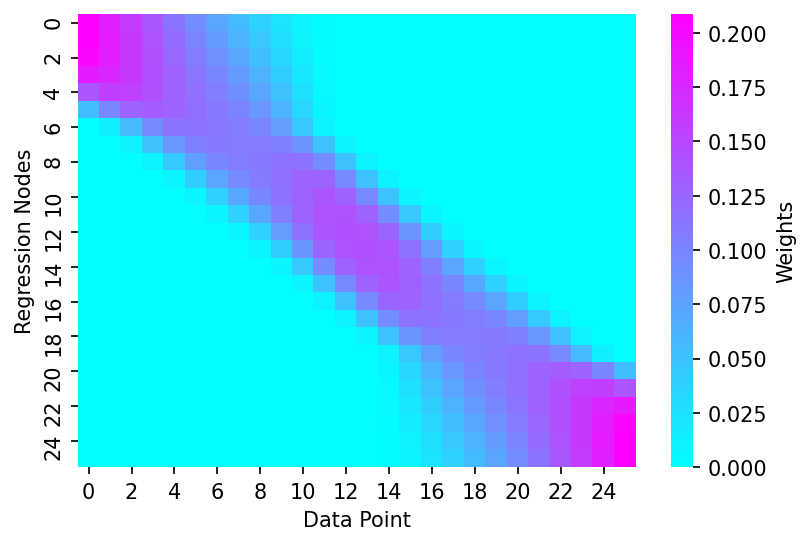

In [37]:
dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)
weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(weights, cmap='cool', cbar_kws={'label':'Weights'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

However if we specify `num_fits` as 10 we can see that only 10 regression nodes are defined in the weights matrix

Text(69.58333333333334, 0.5, 'Regression Nodes')

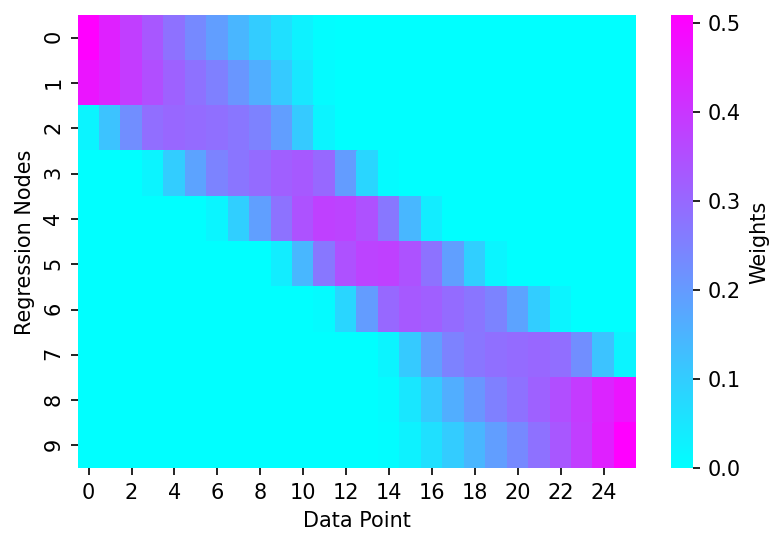

In [38]:
num_fits = 10

dist_matrix = create_dist_matrix(x, num_fits=num_fits)
dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)
weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(weights, cmap='cool', cbar_kws={'label':'Weights'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

But what about if you were only really interested in getting highly localised regressions for a specific part of your variable space? Using the reg_anchors variable we can now specify our own grid over which to carry out the regressions.

Text(69.58333333333334, 0.5, 'Regression Nodes')

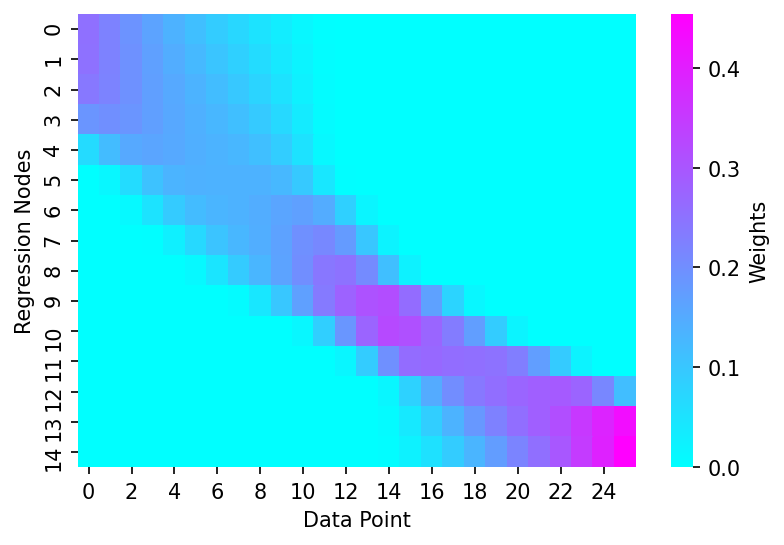

In [39]:
reg_anchors = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 4.5, 5])

dist_matrix = create_dist_matrix(x, reg_anchors=reg_anchors)
dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)
weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(weights, cmap='cool', cbar_kws={'label':'Weights'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

We'll wrap these steps up in a couple of functions and add in some syntactic sugar to allow the user to more flexibily specify the distance matrix kwargs

In [40]:
#exports
def get_weights_matrix(x, frac=0.4, weighting_locs=None, reg_anchors=None, num_fits=None):
    """Wrapper for calculating weights from the raw data and LOWESS fraction"""
    frac_idx = get_frac_idx(x, frac)
    
    if weighting_locs is not None:
        dist_matrix = np.abs(weighting_locs - x.reshape(1, -1))
    else:
        dist_matrix = create_dist_matrix(x, reg_anchors=reg_anchors, num_fits=num_fits)
    
    dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)
    weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)
    
    return weights

Text(69.58333333333334, 0.5, 'Regression Nodes')

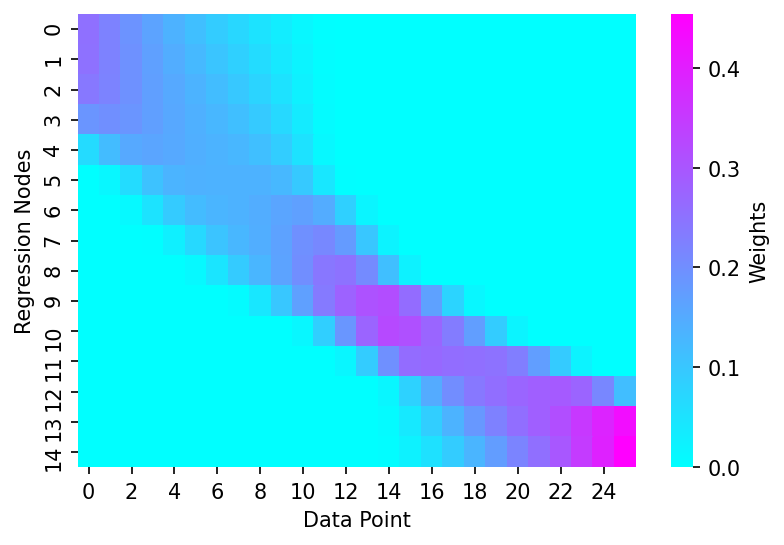

In [41]:
weights = get_weights_matrix(x, frac=0.5, reg_anchors=reg_anchors)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(weights, cmap='cool', cbar_kws={'label':'Weights'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

We'll check this still works when we want to carry out a LOWESS fit over all points

(26, 26)


Text(69.58333333333334, 0.5, 'Regression Nodes')

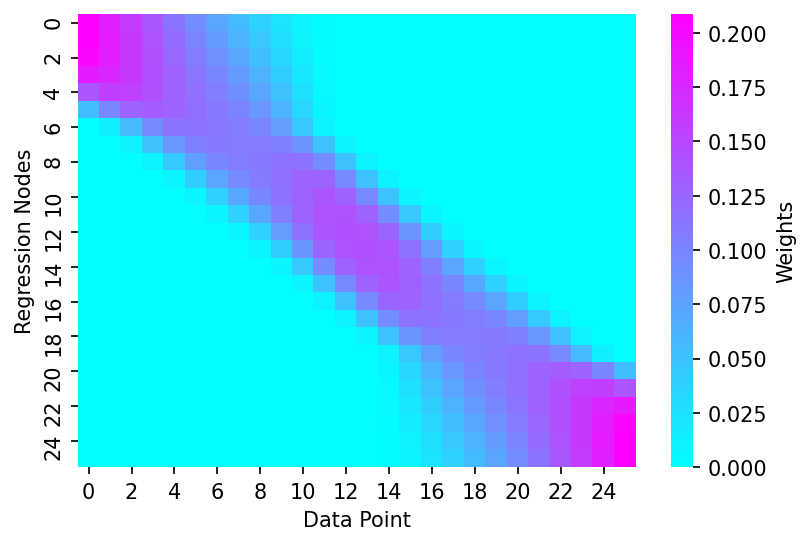

In [42]:
weights = get_weights_matrix(x, frac=frac)

print(weights.shape)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(weights, cmap='cool', cbar_kws={'label':'Weights'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

#### Regression

Now that we've calculated the weightings necessary for local regression we need to create the regression functions. We'll start by calculating the intercept and gradient of a linear regression fit with optional weighting.

N.b. This section of the code was heavily inspired by [this gist](https://gist.github.com/agramfort/850437) created by [Alexandere Gramfort](https://gist.github.com/agramfort)

In [43]:
#exports
def calc_lin_reg_betas(x, y, weights=None):
    """Calculates the intercept and gradient for the specified local regressions"""
    if weights is None:
        weights = np.ones(len(x))
        
    b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
    A = np.array([[np.sum(weights), np.sum(weights * x)],
                  [np.sum(weights * x), np.sum(weights * x * x)]])
    
    betas = np.linalg.lstsq(A, b, rcond=None)[0]
    
    return betas

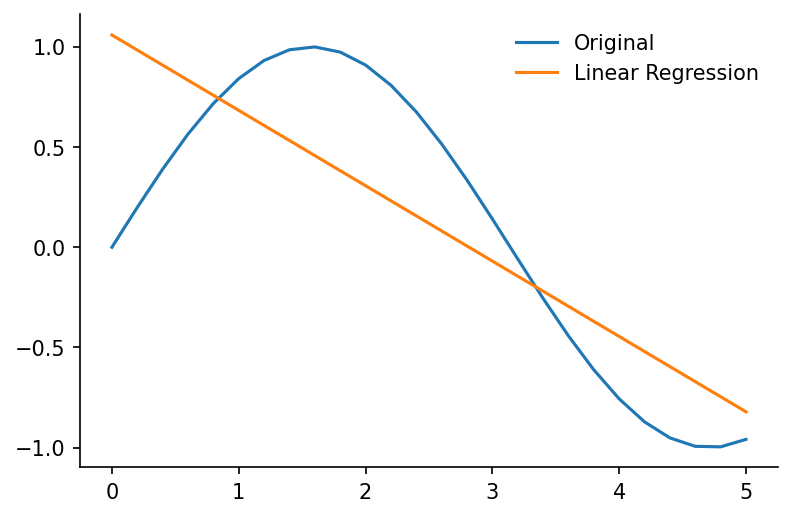

In [44]:
intercept, gradient = calc_lin_reg_betas(x, y)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x, y, label='Original')
ax.plot([x.min(), x.max()], [intercept+gradient*x.min(), intercept+gradient*x.max()], label='Linear Regression')

ax.legend(frameon=False)
eda.hide_spines(ax)

<br>

We'll now repeat the regression calculation but will also specify a weighting for each data-point

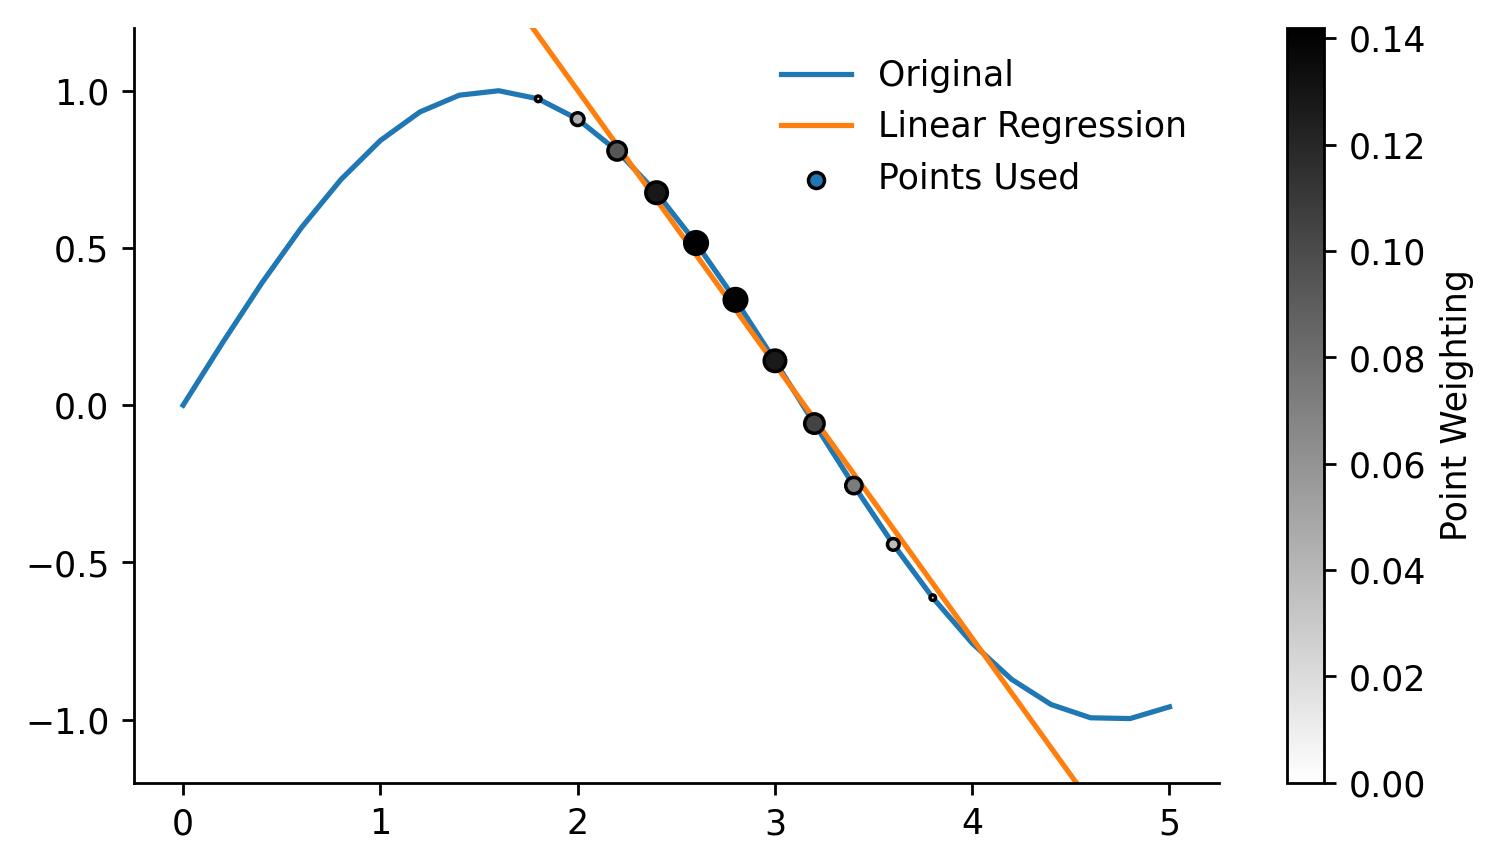

In [47]:
row_weights = weights[14, :]
intercept, gradient = calc_lin_reg_betas(x, y, row_weights)

x_used = x[x*row_weights>0]
y_used = y[x*row_weights>0]
x_weights = row_weights[x*row_weights>0]

## Plotting
fig, ax = plt.subplots(dpi=250, figsize=(7, 4))

weighted_points = ax.scatter(x, y, s=(row_weights)*300, c=row_weights, edgecolor='k', cmap='gray_r', label='Points Used', zorder=3, vmin=0)
cbar = fig.colorbar(weighted_points, label='Point Weighting')

ax.plot(x, y, label='Original')
ax.plot([x.min(), x.max()], [intercept+gradient*x.min(), intercept+gradient*x.max()], label='Linear Regression')

ax.set_ylim(-1.2, 1.2)
eda.hide_spines(ax)

leg = ax.legend(frameon=False)

fig.savefig('../img/LOWESS_single_regression_example.png', dpi=250)

<br>

We can repeat this for all data-points, the error being minimized across these regressions is shown in the equation below

$$
\begin{equation}
  \label{eqn:lowess_err}
  n^{-1} \sum_{i=1}^{n} W_{k i}(x)\left(y_{i}-\sum_{j=0}^{p} \beta_{j} x^{j}\right)^{2}
\end{equation}
$$

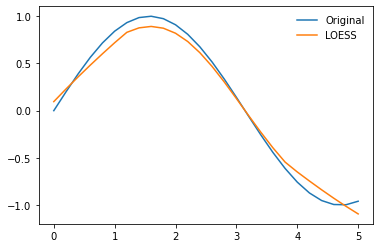

In [46]:
n = len(x)
y_pred = np.zeros(n)

for i in range(n):
    row_weights = weights[i, :]
    betas = calc_lin_reg_betas(x, y, weights[i, :])

    y_pred[i] = betas[0] + betas[1] * x[i]

plt.plot(x, y, label='Original')
plt.plot(x, y_pred, label='LOWESS')
plt.legend(frameon=False)

<br>

Whilst this fit doesn't look great remember we can reduce the fraction of data used in each fit to get a more localised regression, in this example we'll also make use of the `num_fits` parameter to reduce the number of computations that are run.

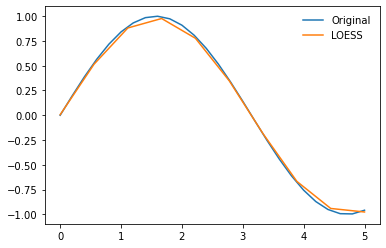

In [47]:
num_fits = 10

weights = get_weights_matrix(x, frac=0.2, num_fits=num_fits)

x_pred = num_fits_2_reg_anchors(x, num_fits).reshape(-1, 1)
y_pred = np.zeros(len(x_pred))

for i in range(len(x_pred)):
    row_weights = weights[i, :]
    betas = calc_lin_reg_betas(x, y, row_weights)

    y_pred[i] = betas[0] + betas[1] * x_pred[i]

plt.plot(x, y, label='Original')
plt.plot(x_pred, y_pred, label='LOWESS')
plt.legend(frameon=False)

<br>

Rather than  carrying out the regression fitting and prediction together we'll seperate them to add some flexibility, for example we wouldnt be able to make predictions with a specified number of polynomial fits using the code we just wrote. 

For this fitting function we'll introduce a design matrix which will hold the coefficients for all of our regressions. We'll also make the function used for regression a parameter, this will allow us to replace it with other regression functions (e.g. polynomials) later on.

In [48]:
#exports
check_array = lambda array, x: np.ones(len(x)) if array is None else array

def fit_regressions(x, y, weights=None, reg_func=calc_lin_reg_betas, num_coef=2, **reg_params):
    """Calculates the design matrix for the specified local regressions"""
    if weights is None:
        weights = np.ones(len(x))
        
    n = weights.shape[0]
    
    y_pred = np.zeros(n)
    design_matrix = np.zeros((n, num_coef))
    
    for i in range(n):
        design_matrix[i, :] = reg_func(x, y, weights=weights[i, :], **reg_params)
        
    return design_matrix

In [49]:
weights = get_weights_matrix(x, frac=0.4, num_fits=10)
design_matrix = fit_regressions(x, y, weights)

design_matrix

array([[ 0.05905438,  0.73999059],
       [ 0.08020775,  0.6991559 ],
       [ 0.35324949,  0.41467757],
       [ 1.09720376, -0.10762239],
       [ 2.03581046, -0.58348682],
       [ 2.77888971, -0.88141726],
       [ 2.91594092, -0.92733431],
       [ 2.05244287, -0.68647646],
       [ 0.84017439, -0.38519789],
       [ 0.6033549 , -0.33232683]])

<br>

We can use this design matrix to create predictions for every local regression, then combine them based on their weightings

In [50]:
#exports
def lowess_fit_and_predict(x, y, frac=0.4, reg_anchors=None, num_fits=None, x_pred=None):
    """Fits and predicts smoothed local regressions at the specified locations"""
    weighting_locs = get_weighting_locs(x, reg_anchors=reg_anchors, num_fits=num_fits)
    weights = get_weights_matrix(x, frac=frac, weighting_locs=weighting_locs)
    design_matrix = fit_regressions(x, y, weights)
    
    if x_pred is None:
        x_pred = x

    point_evals = design_matrix[:, 0] + np.dot(x_pred.reshape(-1, 1), design_matrix[:, 1].reshape(1, -1))
    pred_weights = get_weights_matrix(x_pred, frac=frac, reg_anchors=weighting_locs)
    
    y_pred = np.multiply(pred_weights, point_evals.T).sum(axis=0)
    
    return y_pred

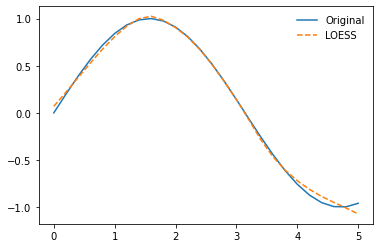

In [51]:
x = np.linspace(0, 5, num=26)
y = np.sin(x)

y_pred = lowess_fit_and_predict(x, y)

plt.plot(x, y, label='Original')
plt.plot(x, y_pred, '--', label='LOWESS')
plt.legend(frameon=False)

<br>

If we pass an array to the `x_pred` parameter then those values will be used as the locations of the output predictions

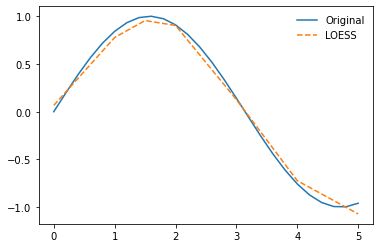

In [52]:
x_pred = np.array([0, 1, 1.5, 2, 3, 4, 5])
y_pred = lowess_fit_and_predict(x, y, num_fits=10, x_pred=x_pred)

plt.plot(x, y, label='Original')
plt.plot(x_pred, y_pred, '--', label='LOESS')
plt.legend(frameon=False)

<br>

Lets do some time tests, starting with a small dataset

In [53]:
x = np.linspace(0, 5, num=26)
y = np.sin(x)

In [54]:
%%timeit

y_pred = lowess_fit_and_predict(x, y)

2.02 ms ± 57.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br>

Even with larger datasets it remains performant

In [55]:
x = np.linspace(0, 5, num=3000)
y = np.sin(x)

frac = 0.1
x_pred = np.linspace(0, 5, 100)[1:] # to avoid divide by zero in MAPE calc

In [56]:
%%timeit

y_pred = lowess_fit_and_predict(x, y, frac=frac, x_pred=x_pred)

989 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>

When making predictions with large datasets and low fractions we can achieve low error for the simple sin curve fitting example

In [57]:
y_pred = lowess_fit_and_predict(x, y, frac=frac, x_pred=x_pred)
y_true = np.sin(x_pred)

print(f'MAPE: {round(100*np.abs((y_true-y_pred)/y_true).mean(), 3)}%')

MAPE: 0.084%


<br>

#### LOWESS on Real-World Data

We'll now evaluate the LOWESS fit on some real data, we'll start by loading the electric insights dataset

In [58]:
%%time

df_EI = eda.load_EI_df('../data/raw/electric_insights.csv')

df_EI.head()

Wall time: 1.86 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


<br>

We'll start by extracting the X and y data

In [59]:
y_col = 'day_ahead_price'
X_cols = ['demand']

yX = df_EI['2020':][[y_col]+X_cols].dropna().values

y = yX[:, 0]
X = yX[:, 1:]

print(y.shape, X.shape)

(17435,) (17435, 1)


<br>

We'll then fit the model and make the prediction

In [60]:
%%time

x = X[:, 0]

x_pred = np.linspace(15, 55, 41)
y_pred = lowess_fit_and_predict(x, y, frac=0.4, num_fits=25, x_pred=x_pred)

Wall time: 63 ms


<br>

And now we can plot the results!

Text(0, 0.5, 'Day-Ahead Price (£/MWh)')

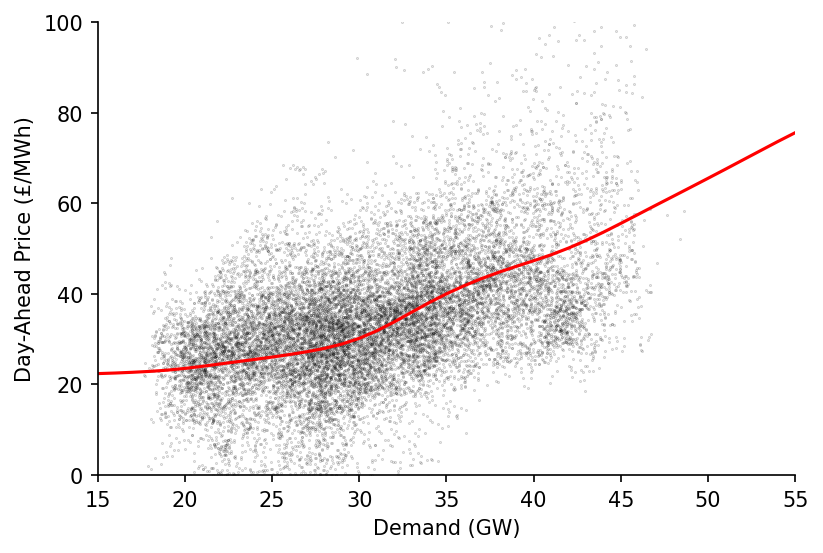

In [61]:
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, c='r')
ax.scatter(x, y, s=0.1, c='k', alpha=0.25)

ax.set_ylim(0, 100)
ax.set_xlim(15, 55)
eda.hide_spines(ax)
ax.set_xlabel('Demand (GW)')
ax.set_ylabel('Day-Ahead Price (£/MWh)')

<br>

#### Robust Regression

What we've done so far is ultimately nothing more than an extension of linear regression, which has been achieved by fitting multiple regressions and manipulating the weighting of the data points used in each one.

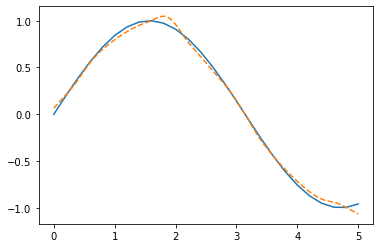

In [62]:
x = np.linspace(0, 5, num=26)
y = np.sin(x)

x_pred = np.linspace(0, 5, 100)
y_pred = lowess_fit_and_predict(x, y, num_fits=5, x_pred=x_pred)

plt.plot(x, y)
plt.plot(x_pred, y_pred, '--')

<br>

But we can also do much more with the weights, including adjusting them to make our regression more robust against outliers. First we'll create a new dataset which has some noise.

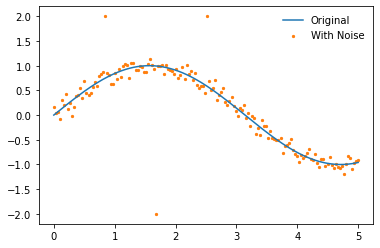

In [63]:
x = np.linspace(0, 5, num=150)
weights = get_weights_matrix(x, frac=0.2)

y = np.sin(x)
y_noisy = y + (np.random.normal(size=len(y)))/10

y_noisy[25] = 2
y_noisy[50] = -2
y_noisy[75] = 2

plt.plot(x, y, label='Original', zorder=2)
plt.scatter(x, y_noisy, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

<br>

We can use our `lowess_fit_and_predict` function to make a lowess model of this data

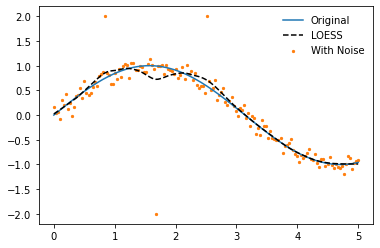

In [64]:
y_pred = lowess_fit_and_predict(x, y_noisy, frac=0.2, num_fits=25) 

plt.plot(x, y, label='Original', zorder=2)
plt.plot(x, y_pred, '--', label='LOWESS', color='k', zorder=3)
plt.scatter(x, y_noisy, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

<br>

The issue though is that our model is being highly skewed by the outliers present in the data, robust regression provides a method to handle this (some improvements can also be made by increasing the `frac` value). To carry it out we need to repeat the lowess fit, but when we do we must further weight the data-points to minimize the influence of outliers.

> Robust regression is an iterative procedure that seeks to identify outliers and minimize their impact on the coefficient estimates - [NCSS](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Robust_Regression.pdf)

Cleveland, W. S. (1979) in his paper 'Robust Locally Weighted Regression and Smoothing Scatterplots' outlines a procedure for carrying out robust lowess regression that we will use here.

We'll start by calculating the standard deviation of the residuals.

In [65]:
residuals = y_noisy - y_pred
std_dev = np.quantile(np.abs(residuals), 0.682)

std_dev

0.13459575203567298

<br>

We can then define a threshold, say 6 standard deviations, and clip any values outside of that. We're left with a cleaned version of the residuals.

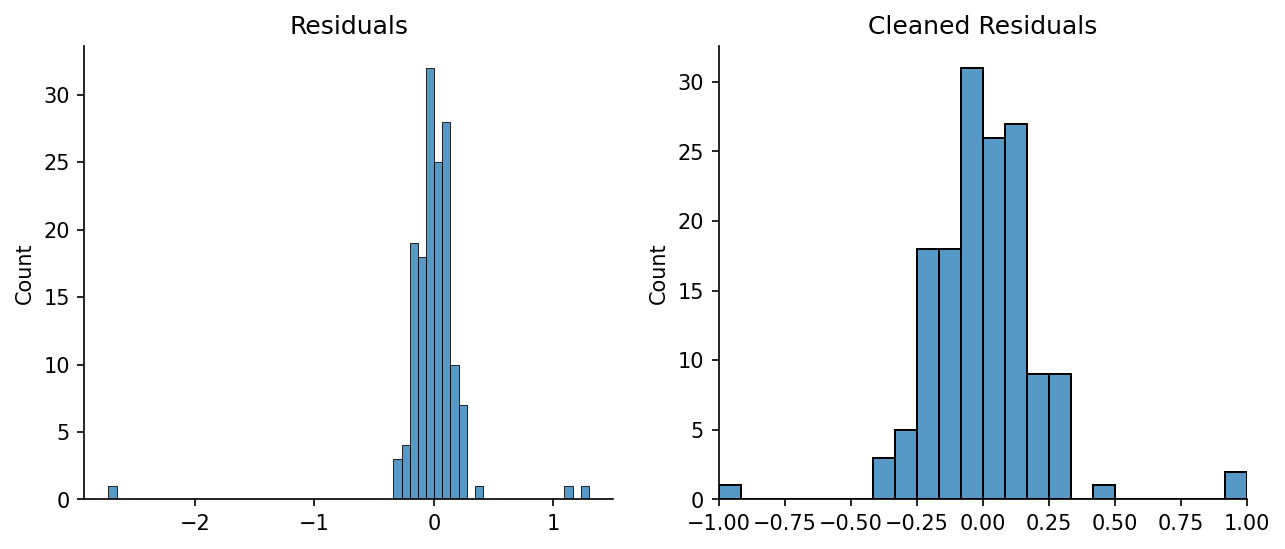

In [66]:
max_std_dev = 6

cleaned_residuals = np.clip(residuals / (max_std_dev * std_dev), -1, 1)

# Plotting
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(10, 4))

ax = axs[0]
sns.histplot(residuals, ax=ax)
ax.set_title('Residuals')

ax = axs[1]
sns.histplot(cleaned_residuals, ax=ax)
ax.set_xlim(-1, 1)
ax.set_title('Cleaned Residuals')

for ax in axs:
    eda.hide_spines(ax)

<br>

In the last step we clipped all of our values from -1 to +1, that means if we square our values and deduct them from 1 any outliers will go to 0. The returned vector we'll call the `robust_weights`. 

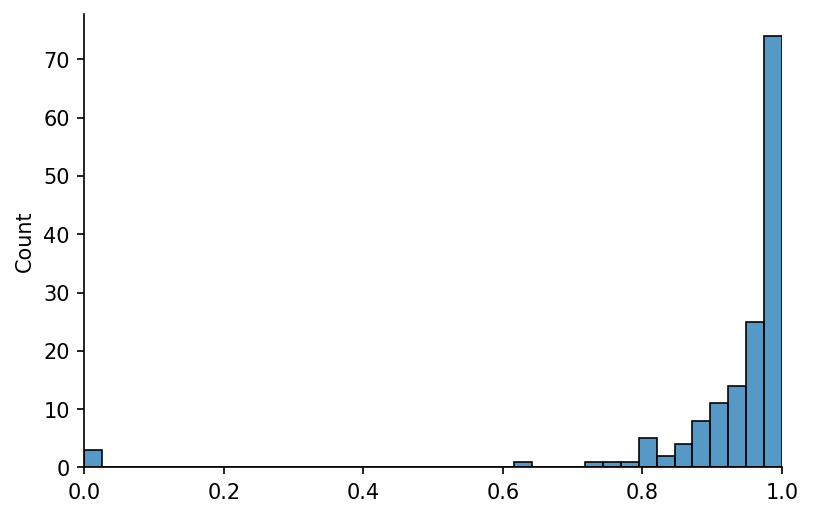

In [67]:
robust_weights = (1 - cleaned_residuals ** 2) ** 2

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(robust_weights, ax=ax)

ax.set_xlim(0, 1)
eda.hide_spines(ax)

<br>

Before we move on we'll combine these into a single step for calculating the `robust_weights`

In [68]:
#exports
def calc_robust_weights(y, y_pred, max_std_dev=6):
    """Calculates robustifying weightings that penalise outliers"""
    residuals = y - y_pred
    std_dev = np.quantile(np.abs(residuals), 0.682)

    cleaned_residuals = np.clip(residuals / (max_std_dev * std_dev), -1, 1)
    robust_weights = (1 - cleaned_residuals ** 2) ** 2
    
    return robust_weights

<br>

We'll now refactor our previous `lowess_fit_and_predict` but this time will enable it to carry out robust regressions

In [69]:
#exports
def robust_lowess_fit_and_predict(x, y, frac=0.4, reg_anchors=None, num_fits=None, x_pred=None, robust_weights=None, robust_iters=3):
    """Fits and predicts robust smoothed local regressions at the specified locations"""
    # Identifying the initial loading weights
    weighting_locs = get_weighting_locs(x, reg_anchors=reg_anchors, num_fits=num_fits)
    loading_weights = get_weights_matrix(x, frac=frac, weighting_locs=weighting_locs)
    
    # Robustifying the weights (to reduce outlier influence)
    if robust_weights is None:
        robust_loading_weights = loading_weights
    else:
        robust_loading_weights = np.multiply(robust_weights, loading_weights)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            robust_loading_weights = robust_loading_weights/robust_loading_weights.sum(axis=0)
        
        robust_loading_weights = np.where(~np.isfinite(robust_loading_weights), 0, robust_loading_weights)
    
    # Fitting the model and making predictions
    design_matrix = fit_regressions(x, y, robust_loading_weights)
    
    if x_pred is None:
        x_pred = x

    point_evals = design_matrix[:, 0] + np.dot(x_pred.reshape(-1, 1), design_matrix[:, 1].reshape(1, -1))
    pred_weights = get_weights_matrix(x_pred, frac=frac, reg_anchors=weighting_locs)
    
    y_pred = np.multiply(pred_weights, point_evals.T).sum(axis=0)
    
    # Recursive robust regression
    robust_weights = calc_robust_weights(y, y_pred)
    
    if robust_iters > 1:
        robust_iters -= 1
        y_pred = robust_lowess_fit_and_predict(x, y, frac=frac, reg_anchors=reg_anchors, num_fits=num_fits, x_pred=x_pred, robust_weights=robust_weights, robust_iters=robust_iters)
    
    return y_pred

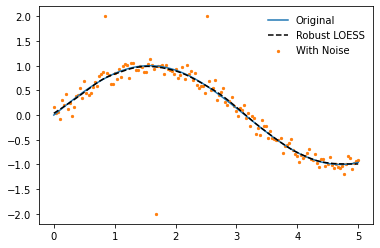

In [70]:
y_pred = robust_lowess_fit_and_predict(x, y_noisy, frac=0.2, num_fits=25) 

plt.plot(x, y, label='Original', zorder=2)
plt.plot(x, y_pred, '--', label='Robust LOWESS', color='k', zorder=3)
plt.scatter(x, y_noisy, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

<br>

We've got everything working nicely but the current way we make predictions doesn't make it easy to plug-and-play with other Python libraries, to reduce this friction we'll refactor the code again and create a Scikit-Learn wrapper for our process.

In [75]:
#exports
class Lowess(BaseEstimator, RegressorMixin):
    """
    This class provides a Scikit-Learn compatible model for Locally Weighted
    Scatterplot Smoothing, including robustifying procedures against outliers.
    
    For more information on the underlying algorithm please refer to
    * William S. Cleveland: "Robust locally weighted regression and smoothing
      scatterplots", Journal of the American Statistical Association, December 1979,
      volume 74, number 368, pp. 829-836.
    * William S. Cleveland and Susan J. Devlin: "Locally weighted regression: An
      approach to regression analysis by local fitting", Journal of the American
      Statistical Association, September 1988, volume 83, number 403, pp. 596-610.
    
    Example Usage:
    ```
    x = np.linspace(0, 5, num=150)
    y = np.sin(x)
    y_noisy = y + (np.random.normal(size=len(y)))/10

    lowess = Lowess()
    lowess.fit(x, y_noisy, frac=0.2)

    x_pred = np.linspace(0, 5, 26)
    y_pred = lowess.predict(x_pred)
    ```
    
    Initialisation Parameters:
        reg_func: function that accepts the x and y values then returns the intercepts and gradients
        
    Attributes:
        reg_func: function that accepts the x and y values then returns the intercepts and gradients
        fitted: Boolean flag indicating whether the model has been fitted
        frac: Fraction of the dataset to use in each local regression
        weighting_locs: Locations of the local regression centers
        loading_weights: Weights of each data-point across the localalised models
        design_matrix: Regression coefficients for each of the localised models
    """
    
    def __init__(self, reg_func=calc_lin_reg_betas):
        self.reg_func = reg_func
        self.fitted = False
        return
        
        
    def calculate_loading_weights(self, x, reg_anchors=None, num_fits=None, external_weights=None, robust_weights=None):
        """
        Calculates the loading weights for each data-point across the localised models
        
        Parameters:
            x: values for the independent variable
            reg_anchors: Locations at which to center the local regressions
            num_fits: Number of locations at which to carry out a local regression
            external_weights: Further weighting for the specific regression
            robust_weights: Robustifying weights to remove the influence of outliers
        """
        
        # Calculating the initial loading weights
        weighting_locs = get_weighting_locs(x, reg_anchors=reg_anchors, num_fits=num_fits)
        loading_weights = get_weights_matrix(x, frac=self.frac, weighting_locs=weighting_locs)
        
        # Applying weight adjustments
        if external_weights is None:
            external_weights = np.ones(x.shape[0])
            
        if robust_weights is None:
            robust_weights = np.ones(x.shape[0])
        
        weight_adj = np.multiply(external_weights, robust_weights)
        loading_weights = np.multiply(weight_adj, loading_weights)
            
        # Post-processing weights
        with np.errstate(divide='ignore', invalid='ignore'):
            loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising
            
        loading_weights = np.where(~np.isfinite(loading_weights), 0, loading_weights) # removing non-finite values
        
        self.weighting_locs = weighting_locs
        self.loading_weights = loading_weights
            
        return 
 

    def fit(self, x, y, frac=0.4, reg_anchors=None, 
            num_fits=None, external_weights=None, 
            robust_weights=None, robust_iters=3, **reg_params):
        """
        Calculation of the local regression coefficients for 
        a LOWESS model across the dataset provided. This method 
        will reassign the `frac`, `weighting_locs`, `loading_weights`,  
        and `design_matrix` attributes of the `Lowess` object.
        
        Parameters:
            x: values for the independent variable
            y: values for the dependent variable
            frac: LOWESS bandwidth for local regression as a fraction
            reg_anchors: Locations at which to center the local regressions
            num_fits: Number of locations at which to carry out a local regression
            external_weights: Further weighting for the specific regression
            robust_weights: Robustifying weights to remove the influence of outliers
            robust_iters: Number of robustifying iterations to carry out
        """
        
        self.frac = frac
        
        # Solving for the design matrix
        self.calculate_loading_weights(x, reg_anchors=reg_anchors, num_fits=num_fits, external_weights=external_weights, robust_weights=robust_weights)
        self.design_matrix = fit_regressions(x, y, weights=self.loading_weights, reg_func=self.reg_func, **reg_params)
    
        # Recursive robust regression
        if robust_iters > 1:
            y_pred = self.predict(x)
            robust_weights = calc_robust_weights(y, y_pred)
            
            robust_iters -= 1
            y_pred = self.fit(x, y, frac=self.frac, reg_anchors=reg_anchors, num_fits=num_fits, external_weights=external_weights, robust_weights=robust_weights, robust_iters=robust_iters, **reg_params)
            
            return y_pred
        
        self.fitted = True
        
        return 
 

    def predict(self, x_pred):
        """
        Inference using the design matrix from the LOWESS fit
        
        Parameters:
            x_pred: Locations for the LOWESS inference

        Returns:
            y_pred: Estimated values using the LOWESS fit
        """
        
        point_evals = self.design_matrix[:, 0] + np.dot(x_pred.reshape(-1, 1), self.design_matrix[:, 1].reshape(1, -1))
        pred_weights = get_weights_matrix(x_pred, frac=self.frac, reg_anchors=self.weighting_locs)
        
        y_pred = np.multiply(pred_weights, point_evals.T).sum(axis=0)
        
        return y_pred

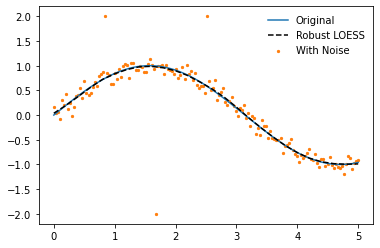

In [77]:
lowess = Lowess()
lowess.fit(x, y_noisy, frac=0.2)

x_pred = np.linspace(0, 5, 26)
y_pred = lowess.predict(x_pred)

# Plotting
plt.plot(x, y, label='Original', zorder=2)
plt.plot(x_pred, y_pred, '--', label='Robust LOWESS', color='k', zorder=3)
plt.scatter(x, y_noisy, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

<br>

### Confidence Intervals

* Create the ensemble_results then take the specified confidence range
* Put into an sklearn wrapper

We're now able to take noisy data and find a robust estimate for the average value at any point, but what about uncertainty? In this work we'll look at two types of uncertainty quantification: confidence & prediction intervals. In this section we will discuss confidence intervals, summarised well in this statement:

> The selection of a confidence level for an interval determines the probability that the confidence interval produced will contain the true parameter value - [stat.yale.edu](http://www.stat.yale.edu/Courses/1997-98/101/confint.htm)

We'll start by creating a slightly noiser and longer sin curve than used previously.

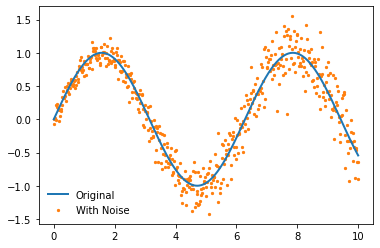

In [78]:
x = np.linspace(0, 10, num=500)
y = np.sin(x)

heteroskedasticity_factor = (1 + 2*np.array(range(len(x)))/len(x))/10
y_noisy = y + heteroskedasticity_factor*(np.random.normal(size=len(y)))

plt.plot(x, y, label='Original', linewidth=2, zorder=2)
plt.scatter(x, y_noisy, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

<br>

To determine the confidence in our estimate we want to know how the model will perform against previously unseen data-points. We can randomly separate our data, calculate the error, then repeat many times to obtain a set of possible errors along the curve - this is a specific use-case of the more general bootstrapping approach.

To generate bootstrapped statistics we first need to split our data set, we'll begin by creating a function that returns the indexes for our in- and out-of-bag samples.

In [79]:
#exports
def get_bootstrap_idxs(x, bootstrap_bag_size=0.5):
    """Determines the indexes of an array to be used for the in- and out-of-bag bootstrap samples"""
    # Bag size handling
    assert bootstrap_bag_size>0, 'Bootstrap bag size must be greater than 0'

    if bootstrap_bag_size > 1:
        assert int(bootstrap_bag_size) == bootstrap_bag_size, 'If the bootstrab bag size is not provided as a fraction then it must be an integer'

    else:
        bootstrap_bag_size = int(np.ceil(bootstrap_bag_size*len(x)))

    # Splitting in-bag and out-of-bag samlpes
    idxs = np.array(range(len(x)))

    ib_idxs = np.sort(np.random.choice(idxs, bootstrap_bag_size, replace=True))
    oob_idxs = np.setdiff1d(idxs, ib_idxs)
    
    return ib_idxs, oob_idxs

In [80]:
ib_idxs, oob_idxs = get_bootstrap_idxs(x)

print(f'in-bag: {len(ib_idxs)}, out-of-bag: {len(oob_idxs)}')

in-bag: 250, out-of-bag: 299


<br>

We'll now calculate the standard deviation of the in- and out-of-bag errors

In [81]:
#exports
def get_bootstrap_resid_std_devs(x, y, bag_size, model=Lowess(), **model_kwargs):
    """Calculates the standard deviation of the in- and out-of-bag errors"""
    # Splitting the in- and out-of-bag samples
    ib_idxs, oob_idxs = get_bootstrap_idxs(x, bag_size)

    x_ib, x_oob = x[ib_idxs], x[oob_idxs]
    y_ib, y_oob = y[ib_idxs], y[oob_idxs]

    # Fitting and predicting with the model
    model.fit(x_ib, y_ib, **model_kwargs)

    y_pred = model.predict(x)
    y_ib_pred = model.predict(x_ib)
    y_oob_pred = model.predict(x_oob)

    # Calculating the error
    y_ib_resids = y_ib - y_ib_pred
    ib_resid_std_dev = np.std(np.abs(y_ib_resids))

    y_oob_resids = y_oob - y_oob_pred
    oob_resid_std_dev = np.std(np.abs(y_oob_resids))

    return ib_resid_std_dev, oob_resid_std_dev

In [82]:
get_bootstrap_resid_std_devs(x, y, bag_size=0.5, frac=0.2, num_fits=20)

(0.020320708955639148, 0.024223597689702395)

<br>

We'll quickly plot the distributions of the errors for each set

 [████████████████████████████████████████████████████████████] 1000/1000 [00:28<00:00, 0.03s/it]

Text(0.5, 0, "Residual's Standard Deviation")

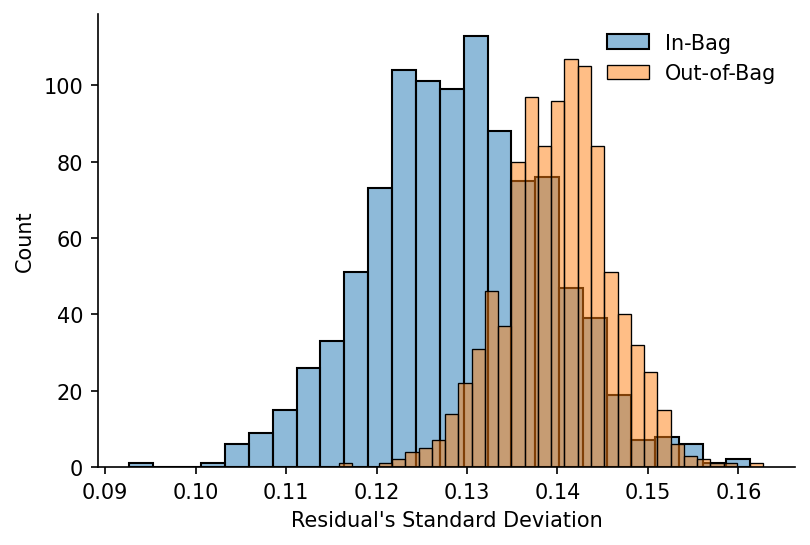

In [83]:
bag_size = 0.5
num_runs = 1000

ib_resid_std_devs = []
oob_resid_std_devs = []

for model_run in track(range(num_runs)):
    ib_resid_std_dev, oob_resid_std_dev = get_bootstrap_resid_std_devs(x, y_noisy, bag_size, frac=0.2, num_fits=20)
    
    ib_resid_std_devs += [ib_resid_std_dev]
    oob_resid_std_devs += [oob_resid_std_dev]
    
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(ib_resid_std_devs, ax=ax, alpha=0.5, label='In-Bag')
sns.histplot(oob_resid_std_devs, ax=ax, alpha=0.5, color='C1', label='Out-of-Bag')

ax.legend(frameon=False)
eda.hide_spines(ax)
ax.set_xlabel('Residual\'s Standard Deviation')

<br>

We'll now create two wrapper functions, one for running models, the other for bootstrapping them. The returned `df_bootstrap` includes the predictions for each model run.

N.b. the `bootstrap_model` is a generalisable function that will work with any Scikit-Learn compatible model.

In [84]:
#exports
def run_model(x, y, bag_size, model=Lowess(), x_pred=None, **model_kwargs):
    """Fits a model and then uses it to make a prediction"""
    if x_pred is None:
        x_pred = x
        
    # Splitting the in- and out-of-bag samples
    ib_idxs, oob_idxs = get_bootstrap_idxs(x, bag_size)
    x_ib, y_ib = x[ib_idxs], y[ib_idxs]

    # Fitting and predicting the model
    model.fit(x_ib, y_ib, **model_kwargs)
    y_pred = model.predict(x_pred)
    
    return y_pred

def bootstrap_model(x, y, bag_size=0.5, model=Lowess(), x_pred=None, num_runs=1000, **model_kwargs):
    """Repeatedly fits and predicts using the specified model, using different subsets of the data each time"""
    # Creating the ensemble predictions
    preds = []

    for bootstrap_run in range(num_runs):
        y_pred = run_model(x, y, bag_size, model=model, x_pred=x_pred, **model_kwargs)
        preds += [y_pred]

    # Wrangling into a dataframe
    df_bootstrap = pd.DataFrame(preds, columns=x).T

    df_bootstrap.index.name = 'x'
    df_bootstrap.columns.name = 'bootstrap_run'

    return df_bootstrap

In [85]:
df_bootstrap = bootstrap_model(x, y_noisy, num_runs=1000, frac=0.2, num_fits=20)

df_bootstrap.head()

 [████████████████████████████████████████████████████████████] 1000/1000 [00:25<00:00, 0.03s/it]

bootstrap_run,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
x,,,,,,,,,,,,,,,,,,,,,
0.00000,0.123240,0.100568,0.034607,0.062935,0.037283,0.024595,0.077896,0.071517,0.154899,0.104609,...,0.106006,0.022008,0.117897,0.042924,0.094948,0.095224,0.109828,0.097625,0.096894,0.102314
0.02004,0.135523,0.114414,0.048940,0.077258,0.051836,0.039222,0.091694,0.086137,0.166246,0.116779,...,0.119922,0.037429,0.131267,0.057019,0.109155,0.107799,0.122830,0.111439,0.109543,0.115580
0.04008,0.147791,0.128252,0.063258,0.091566,0.066380,0.053843,0.105484,0.100748,0.177581,0.128936,...,0.133827,0.052831,0.144617,0.071105,0.123350,0.120364,0.135816,0.125241,0.122177,0.128832
0.06012,0.160044,0.142084,0.077562,0.105860,0.080914,0.068458,0.119268,0.115353,0.188904,0.141083,...,0.147722,0.068217,0.157946,0.085199,0.137534,0.132918,0.148786,0.139030,0.134797,0.142070
0.08016,0.172286,0.155927,0.091852,0.120165,0.095440,0.083068,0.133063,0.129976,0.200216,0.153222,...,0.161608,0.083587,0.171256,0.099382,0.151709,0.145480,0.161742,0.152810,0.147405,0.155300


<br>

Using `df_bootstrap` we can calculate the confidence interval of our predictions, the Pandas DataFrame `quantile` method makes this particularly simple.

In [86]:
#exports
def get_confidence_interval(df_bootstrap, conf_pct=0.95):
    """Estimates the confidence interval of a prediction based on the bootstrapped estimates"""
    conf_margin = (1 - conf_pct)/2
    df_conf_intvl = pd.DataFrame(columns=['min', 'max'], index=df_bootstrap.index)
    
    df_conf_intvl['min'] = df_bootstrap.quantile(conf_margin, axis=1)
    df_conf_intvl['max'] = df_bootstrap.quantile(1-conf_margin, axis=1)
    
    df_conf_intvl = df_conf_intvl.sort_index()
    
    return df_conf_intvl

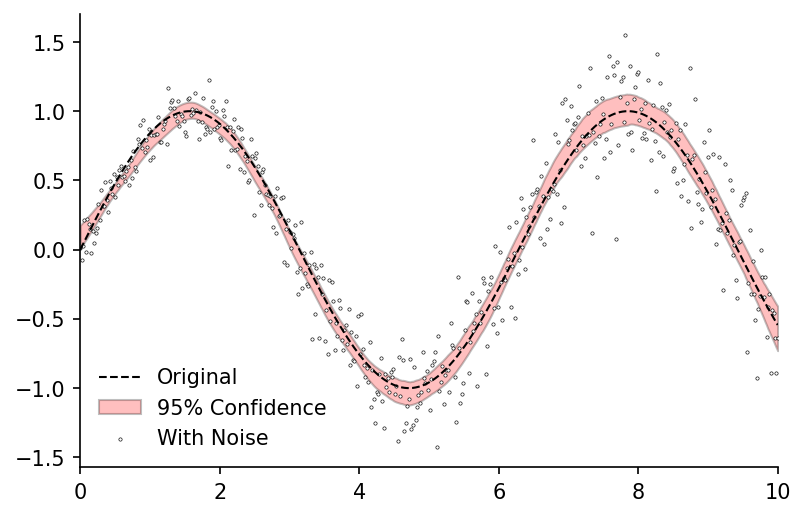

In [87]:
df_conf_intvl = get_confidence_interval(df_bootstrap, conf_pct=0.95)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x, y, 'k--', label='Original', linewidth=1, zorder=2)
ax.fill_between(df_conf_intvl.index, df_conf_intvl['min'], df_conf_intvl['max'], color='r', edgecolor='k', alpha=0.25, label='95% Confidence')
ax.scatter(x, y_noisy, label='With Noise', color='w', edgecolor='k', linewidth=0.3, s=2.5, zorder=1)

ax.legend(frameon=False)
ax.set_xlim(0, 10)
eda.hide_spines(ax)

<br>

### Quantile Predictions

Earlier when creating our `Lowess` class we enabled the function used in calculating the design matrix betas to be specified at initialisation. We can now use this to pass a custom function that will calculate the design matrix for a local quantile regression.

In [88]:
#exports
def pred_to_quantile_loss(y, y_pred, q=0.5, weights=None):
    """Calculates the quantile error for a prediction"""
    residuals = y - y_pred
    
    if weights is not None:
        residuals = weights*residuals
    
    loss = np.array([q*residuals, (q-1)*residuals]).max(axis=0).mean()
    
    return loss

def calc_quant_reg_loss(x0, x, y, q, weights=None):
    """Makes a quantile prediction then calculates its error"""
    if weights is None:
        weights = np.ones(len(x))
        
    quantile_pred = x0[0] + x0[1]*x
    loss = pred_to_quantile_loss(y, quantile_pred, q, weights)
    
    return loss

calc_quant_reg_betas = lambda x, y, q=0.5, x0=np.zeros(2), weights=None, method='nelder-mead': minimize(calc_quant_reg_loss, x0, method=method, args=(x, y, q, weights)).x

<br>

We'll then create a wrapper that will fit the model for several specified quantiles.

N.b. this function should generalise to any Scikit-Learn compatible model that uses `q` as the kwarg for the quantile.

In [89]:
#exports
def quantile_model(x, y, model=Lowess(calc_quant_reg_betas), 
                   x_pred=None, qs=np.linspace(0.1, 0.9, 9), **model_kwargs):
    """Model wrapper that will repeatedly fit and predict for the specified quantiles"""

    if x_pred is None:
        x_pred = np.sort(np.unique(x))
        
    q_to_preds = dict()

    for q in qs:
        model.fit(x, y, q=q, **model_kwargs)
        q_to_preds[q] = model.predict(x_pred)

    df_quantiles = pd.DataFrame(q_to_preds, index=x_pred)
    
    df_quantiles.index.name = 'x'
    df_quantiles.columns.name = 'quantiles'

    return df_quantiles

In [90]:
%%time

df_quantiles = quantile_model(x, y_noisy, frac=0.2, num_fits=100, robust_iters=1)

df_quantiles.head()

 [████████████████████████████████████████████████████████████] 9/9 [00:11<00:01, 1.18s/it]

Wall time: 10.6 s


quantiles,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
x,,,,,,,,,
0.00000,-0.071164,-0.004352,0.011374,0.025166,0.080732,0.091657,0.144884,0.163482,0.192227
0.02004,-0.056877,0.009553,0.025934,0.040718,0.095134,0.106431,0.158797,0.178013,0.207308
0.04008,-0.042584,0.023455,0.040493,0.056241,0.109531,0.121194,0.172707,0.192542,0.222345
0.06012,-0.028267,0.037368,0.055069,0.071750,0.123931,0.135959,0.186627,0.207077,0.237343
0.08016,-0.013915,0.051300,0.069668,0.087256,0.138339,0.150735,0.200564,0.221624,0.252307


<br>

We can visualise the range of our predictions

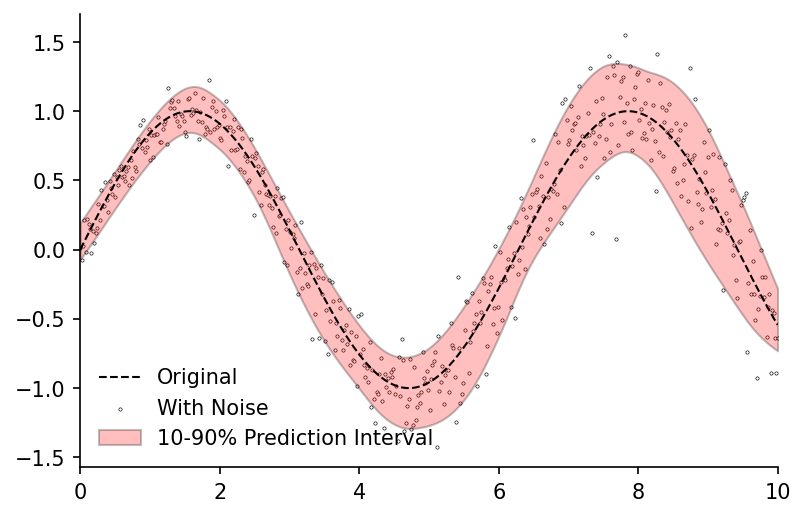

In [91]:
fig, ax = plt.subplots(dpi=150)

ax.plot(x, y, 'k--', label='Original', linewidth=1, zorder=2)
ax.scatter(x, y_noisy, label='With Noise', color='w', edgecolor='k', linewidth=0.3, s=2.5, zorder=1)
ax.fill_between(df_quantiles.index, df_quantiles[0.1], df_quantiles[0.9], color='r', edgecolor='k', alpha=0.25, label='10-90% Prediction Interval')

ax.legend(frameon=False, loc=3)
ax.set_xlim(0, 10)
eda.hide_spines(ax)

<br>

### External Weights

When we made our `Lowess` class we included the option to specify `external_weights`, the reason for this is that it allows us to carry out further model smoothing using variables outside of the regression. This makes particular sense for variables such as time.

Lets first plot two subsets of the data to see why we need to do this in the first place.

Text(0, 0.5, 'Price (£/MWh)')

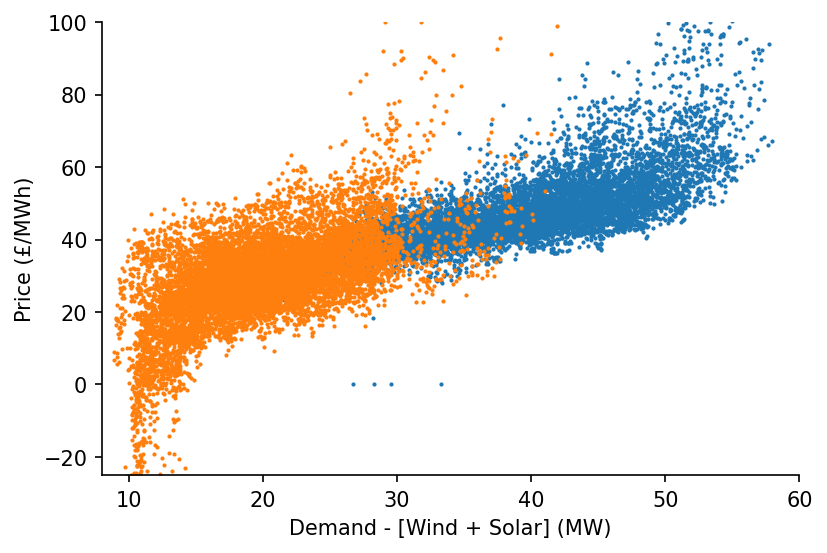

In [105]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable['2010-09':'2011-03'], s_price['2010-09':'2011-03'], s=1)
ax.scatter(s_dispatchable['2020-03':'2020-09'], s_price['2020-03':'2020-09'], s=1)

eda.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

<br>

Lets start by adding some boolean filters that we'll then cast as integers to act as weights, for one we'll choose an early winter period from the dataset, for the other we'll take the latest summer

In [106]:
model_to_dt_weights = {
    'Winter 10-11': ((s_dispatchable.index < '2011-03') & (s_dispatchable.index > '2010-09')).astype(int),
    'Summer 20': ((s_dispatchable.index < '2020-09') & (s_dispatchable.index > '2020-03')).astype(int)
}

df_preds = pd.DataFrame()

for model_name, dt_weights in model_to_dt_weights.items():
    lowess = Lowess()
    lowess.fit(s_dispatchable.values, s_price.values, frac=0.3, num_fits=31, external_weights=dt_weights)

    x_pred = np.linspace(8, 60, 53)
    y_pred = lowess.predict(x_pred)

    df_preds[model_name] = pd.Series(y_pred, index=x_pred)

<br>

We'll plot our estimates alongside the true values

Text(0, 0.5, 'Price (£/MWh)')

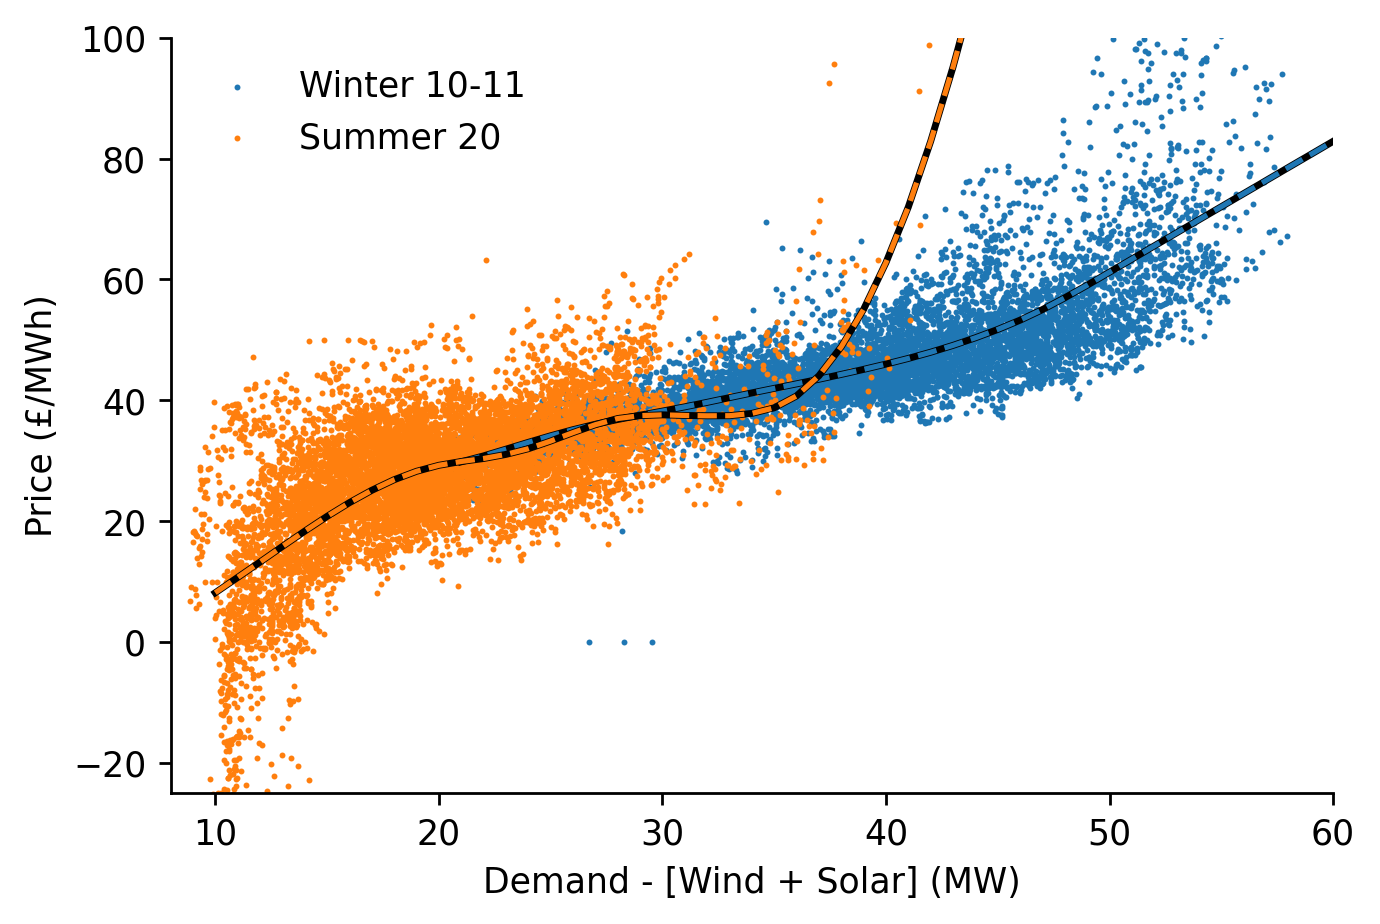

In [107]:
fig, ax = plt.subplots(dpi=250)

for i, (model_name, dt_weights) in enumerate(model_to_dt_weights.items()):
    color = f'C{i}'
    ax.scatter(s_dispatchable[dt_weights.astype(bool)], s_price[dt_weights.astype(bool)], color=color, s=0.5, label=model_name)
    
    min_, max_ = s_dispatchable[dt_weights.astype(bool)].quantile([0.001, 0.99])
    df_preds.loc[df_preds.index>min_, model_name].plot(ax=ax, color='k', linewidth=2, label='_nolegend_')
    df_preds.loc[df_preds.index>min_, model_name].plot(ax=ax, color=color, linestyle='--', label='_nolegend_')

ax.legend(frameon=False)
eda.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

<br>

Instead of just using a boolean value to indicate whether an observation belongs to a specific date period, we could instead assign weightings based on the distance from specific dates. This has the benefit that we can reuse existing functions that we wrote earlier.

In [108]:
#exports
def calc_timedelta_dists(dates, central_date, threshold_value=24, threshold_units='W'):
    """Maps datetimes to weights using the central date and threshold information provided"""
    timedeltas = pd.to_datetime(dates, utc=True) - pd.to_datetime(central_date, utc=True)
    timedelta_dists = timedeltas/pd.Timedelta(value=threshold_value, unit=threshold_units)

    return timedelta_dists

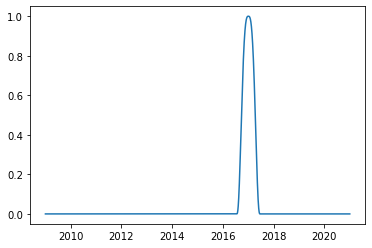

In [109]:
central_date = '2017-01-01'

timedelta_dists = calc_timedelta_dists(df_EI.index, central_date)
weights = dist_to_weights(timedelta_dists.values)

plt.plot(df_EI.index, weights)

<br>

We'll create a wrapper that does this for all of the dates at which we wish to create a localised Lowess model

In [ ]:
#exports
def construct_dt_weights(dt_idx, reg_dates, threshold_value=52, threshold_units='W'):
    """Constructs a set of distance weightings based on the regression dates provided"""
    dt_to_weights = dict()

    for reg_date in reg_dates:
        dt_to_weights[reg_date] = pd.Series(calc_timedelta_dists(dt_idx, reg_date, threshold_value=threshold_value, threshold_units=threshold_units)).pipe(dist_to_weights).values

    return dt_to_weights

Wall time: 2.86 s


<AxesSubplot:ylabel='local_datetime'>

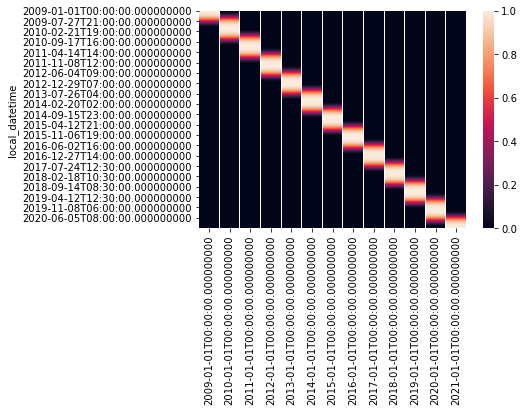

In [147]:
%%time

reg_dates = pd.date_range('2009-01-01', '2021-01-01', freq='Ys')
dt_to_weights = construct_dt_weights(df_EI_model.index, reg_dates)

sns.heatmap(pd.DataFrame(dt_to_weights, index=df_EI_model.index))

<br>

We'll create two wrapper functions for fitting the models and estimating using them as an ensemble. We'll also create a function that sanitises the inputs to the `SmoothDates` fitting method.

In [339]:
#exports
def fit_external_weighted_ensemble(x, y, ensemble_member_to_weights, lowess_kwargs={}, **fit_kwargs):
    """Fits an ensemble of LOWESS models which have varying relevance for each subset of data over time"""
    ensemble_member_to_models = dict()

    for ensemble_member, ensemble_weights in ensemble_member_to_weights.items():
        ensemble_member_to_models[ensemble_member] = Lowess(**lowess_kwargs)
        ensemble_member_to_models[ensemble_member].fit(x, y, external_weights=ensemble_weights, **fit_kwargs)
        
    return ensemble_member_to_models

def get_ensemble_preds(ensemble_member_to_model, x_pred=np.linspace(8, 60, 53)):
    """Using the fitted ensemble of LOWESS models to generate the predictions for each of them"""
    ensemble_member_to_preds = dict()
    
    for ensemble_member in ensemble_member_to_model.keys():
        ensemble_member_to_preds[ensemble_member] = ensemble_member_to_model[ensemble_member].predict(x_pred)
        
    return ensemble_member_to_preds

def process_smooth_dates_fit_inputs(x, y, dt_idx, reg_dates):  
    """Sanitises the inputs to the SmoothDates fitting method"""
    if hasattr(x, 'index') and hasattr(y, 'index'):
        assert x.index.equals(y.index), 'If `x` and `y` have indexes then they must be the same'
        if dt_idx is None:
            dt_idx = x.index

        x = x.values
        y = y.values

    assert dt_idx is not None, '`dt_idx` must either be passed directly or `x` and `y` must include indexes'

    if reg_dates is None:
        reg_dates = dt_idx
    
    return x, y, dt_idx, reg_dates

<br>

We now have everything we need to create our `SmoothDates` class that will enable us to create estimates of the surface fit of a LOWESS model over time

In [15]:
#exports
class SmoothDates(BaseEstimator, RegressorMixin):
    """
    This class provides a time-adaptive extension of the classical 
    Locally Weighted Scatterplot Smoothing regression technique, 
    including robustifying procedures against outliers. This model
    predicts the surface rather than individual point estimates.
    
    Initialisation Parameters:
        frac: Fraction of the dataset to use in each local regression
        threshold_value: Number of datetime units to use in each regression
        threshold_units: Datetime unit which should be compatible with pandas `date_range` function
        
    Attributes:
        fitted: Boolean flag indicating whether the model has been fitted
        frac: Fraction of the dataset to use in each local regression
        threshold_value: Number of datetime units to use in each regression
        threshold_units: Datetime unit which should be compatible with pandas `date_range` function
        ensemble_member_to_weights: Mapping from the regression dates to their respective weightings for each data-point
        ensemble_member_to_models: Mapping from the regression dates to their localised models
        reg_dates: Dates at which the local time-adaptive models will be centered around
        pred_weights: Weightings to map from the local models to the values to be inferenced 
        pred_values: Raw prediction values as generated by each of the individual local models
    """
    
    def __init__(self, frac=0.3, threshold_value=52, threshold_units='W'):
        self.fitted = False
        self.frac = frac
        self.threshold_value = threshold_value
        self.threshold_units = threshold_units
    
    
    def fit(self, x, y, dt_idx=None, reg_dates=None, lowess_kwargs={}, **fit_kwargs): 
        """
        Calculation of the local regression coefficients for each of the
        LOWESS models across the dataset provided. This is a time-adaptive
        ensembled version of the `Lowess` model.
        
        Parameters:
            x: Values for the independent variable
            y: Values for the dependent variable
            dt_idx: Datetime index, if not provided the index of the x and y series will be used
            reg_dates: Dates at which the local time-adaptive models will be centered around
            lowess_kwargs: Additional arguments to be passed at model initialisation
            reg_anchors: Locations at which to center the local regressions
            num_fits: Number of locations at which to carry out a local regression
            external_weights: Further weighting for the specific regression
            robust_weights: Robustifying weights to remove the influence of outliers
            robust_iters: Number of robustifying iterations to carry out
        """
        
        x, y, dt_idx, reg_dates = process_smooth_dates_fit_inputs(x, y, dt_idx, reg_dates)
        self.ensemble_member_to_weights = construct_dt_weights(dt_idx, reg_dates, 
                                                               threshold_value=self.threshold_value, 
                                                               threshold_units=self.threshold_units)
        
        self.ensemble_member_to_models = fit_external_weighted_ensemble(x, y, self.ensemble_member_to_weights, lowess_kwargs=lowess_kwargs, frac=self.frac, **fit_kwargs)
        
        self.reg_dates = reg_dates
        self.fitted = True
        
        return 
    
    
    def predict(self, x_pred=np.linspace(8, 60, 53), dt_pred=None, return_df=True):
        """
        Inference using the design matrix from the time-adaptive LOWESS fits
        
        Parameters:
            x_pred: Independent variable locations for the time-adaptive LOWESS inference
            dt_pred: Date locations  for the time-adaptive LOWESS inference
            return_df: Flag specifying whether to return a dataframe or numpy matrix

        Returns:
            df_pred/y_pred: Estimated surface of the time-adaptive the LOWESS fit
        """
        
        if dt_pred is None:
            dt_pred = self.reg_dates
            
        if isinstance(x_pred, pd.Series):
            x_pred = x_pred.values
            
        self.ensemble_member_to_preds = get_ensemble_preds(self.ensemble_member_to_models, x_pred=x_pred)
        
        self.pred_weights = np.array(list(construct_dt_weights(dt_pred, self.reg_dates).values()))
        
        with np.errstate(divide='ignore', invalid='ignore'):
            self.pred_weights = self.pred_weights/self.pred_weights.sum(axis=0)
            
        self.pred_values = np.array(list(self.ensemble_member_to_preds.values()))
        
        y_pred = np.dot(self.pred_weights.T, self.pred_values)
        
        if return_df == True:
            df_pred = pd.DataFrame(y_pred, index=dt_pred, columns=x_pred).T
            return df_pred
        else:
            return y_pred

In [363]:
%%time

# Fitting
reg_dates = pd.date_range('2009-01-01', '2021-01-01', freq='13W')

smooth_dates = SmoothDates()
smooth_dates.fit(s_dispatchable.values, s_price.values, dt_idx=s_dispatchable.index, 
                 reg_dates=reg_dates, frac=0.3, num_fits=31, threshold_value=26)

# Prediction
x_pred = np.linspace(8, 60, 53)

df_pred = smooth_dates.predict(x_pred=x_pred)

df_pred.head()

Wall time: 206 ms


,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,...,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0
2009-01-04,-25.197904,-19.697833,-14.198458,-8.701850,-3.207986,2.279579,7.766803,13.257105,18.771209,24.339723,...,191.519825,199.994426,208.404577,216.829275,225.204056,233.599836,241.959057,250.321802,258.639183,267.001854
2009-04-05,-35.897568,-28.431147,-20.966206,-13.509113,-6.057171,1.382573,8.824444,16.274388,23.769274,31.357876,...,241.977105,251.959247,261.859975,271.776585,281.632207,291.513745,301.352921,311.197930,320.989457,330.837097
2009-07-05,-36.788636,-28.224829,-19.663715,-11.117691,-2.580427,5.936043,14.457608,22.993449,31.601400,40.352223,...,267.245741,277.279409,287.218735,297.170748,307.058118,316.973593,326.847585,336.730016,346.558220,356.447006
2009-10-04,-18.874849,-10.755134,-2.638993,5.457812,13.543526,21.603363,29.671536,37.762505,45.947349,54.314240,...,258.997653,267.470967,275.842164,284.218523,292.535411,300.879809,309.190859,317.513073,325.788247,334.121138
2010-01-03,10.954660,17.853995,24.749555,31.626960,38.492805,45.332537,52.179803,59.051623,66.018531,73.171976,...,244.871834,251.738222,258.495341,265.250429,271.950819,278.677803,285.379434,292.094949,298.771121,305.502093


<br>

We'll visualise our surface estimate as a wire-plot, where the darker colours denote price curve estimates from longer ago.

(0.0, 400.0)

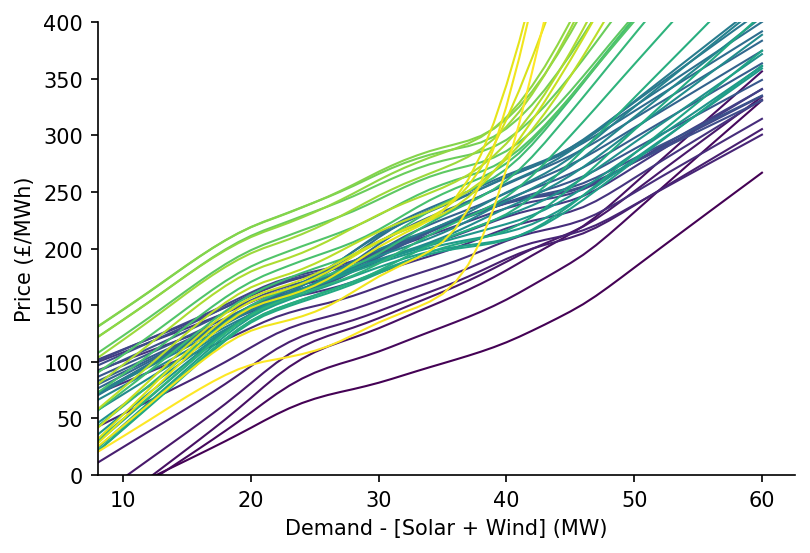

In [397]:
fig, ax = plt.subplots(dpi=150)

df_pred.T.plot(legend=False, cmap='viridis', linewidth=1, ax=ax)

eda.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (MW)')
ax.set_ylabel('Price (£/MWh)')
ax.set_xlim(df_pred.columns[0])
ax.set_ylim(0, 400)

<br>

Whilst `SmoothDates` accepts time-series of dispatchable generation and price as inputs to the `fit` method, `predict` doesn't accept a time-series of dispatchable generation or return a time-series of price estimates. Instead, `predict` returns a dataframe of the smoothed surface - unfortunately this is not what we need if we want to interface our work with the wider Python eco-system for sklearn based models. 

We'll create a further wrapper on top of `SmoothDates` that will accept a time-series of dispatchable generation and return the price estimate when the `predict` method is used. This will later be used for hyper-parameter tuning in, but could also be interfaced with tools such as TPOT for automated pipeline generation (perhaps the MOE estimate could be ensembled as an input to an ML model?).

In [2]:
#exports
def construct_pred_ts(s, df_pred, rounding_dec=1):
    """Uses the time-adaptive LOWESS surface to generate time-series prediction"""
    vals = []
    
    for dt_idx, val in s.iteritems():
        vals += [df_pred.loc[round(val, rounding_dec), dt_idx.strftime('%Y-%m-%d')]]
        
    s_pred_ts = pd.Series(vals, index=s.index)
    
    return s_pred_ts

class LowessDates(BaseEstimator, RegressorMixin):
    """
    This class provides a time-adaptive extension of the classical 
    Locally Weighted Scatterplot Smoothing regression technique, 
    including robustifying procedures against outliers.
    
    Initialisation Parameters:
        frac: Fraction of the dataset to use in each local regression
        threshold_value: Number of datetime units to use in each regression
        threshold_units: Datetime unit which should be compatible with pandas `date_range` function
        
    Attributes:
        fitted: Boolean flag indicating whether the model has been fitted
        frac: Fraction of the dataset to use in each local regression
        threshold_value: Number of datetime units to use in each regression
        threshold_units: Datetime unit which should be compatible with pandas `date_range` function
        ensemble_member_to_weights: Mapping from the regression dates to their respective weightings for each data-point
        ensemble_member_to_models: Mapping from the regression dates to their localised models
        reg_dates: Dates at which the local time-adaptive models will be centered around
        ensemble_member_to_preds: Mapping from the regression dates to their predictions
        reg_weights: Mapping from the prediction values to the weighting of each time-adaptive model 
        reg_values: Predictions from each regression
        df_reg: A DataFrame of the time-adaptive surfce regression
    """
    
    def __init__(self, frac=0.3, threshold_value=52, threshold_units='W', pred_reg_dates=None):
        self.fitted = False
        self.frac = frac
        self.threshold_value = threshold_value
        self.threshold_units = threshold_units
        self.pred_reg_dates = pred_reg_dates
    
    
    def fit(self, x, y, dt_idx=None, reg_dates=None, lowess_kwargs={}, **fit_kwargs):
        """
        Calculation of the local regression coefficients for each of the
        LOWESS models across the dataset provided. This is a time-adaptive
        ensembled version of the `Lowess` model.
        
        Parameters:
            x: Values for the independent variable
            y: Values for the dependent variable
            dt_idx: Datetime index, if not provided the index of the x and y series will be used
            reg_dates: Dates at which the local time-adaptive models will be centered around
            lowess_kwargs: Additional arguments to be passed at model initialisation
            reg_anchors: Locations at which to center the local regressions
            num_fits: Number of locations at which to carry out a local regression
            external_weights: Further weighting for the specific regression
            robust_weights: Robustifying weights to remove the influence of outliers
            robust_iters: Number of robustifying iterations to carry out
        """
        
        x, y, dt_idx, reg_dates = process_smooth_dates_fit_inputs(x, y, dt_idx, reg_dates)
        self.ensemble_member_to_weights = construct_dt_weights(dt_idx, reg_dates, 
                                                               threshold_value=self.threshold_value, 
                                                               threshold_units=self.threshold_units)
        
        self.ensemble_member_to_models = fit_external_weighted_ensemble(x, y, self.ensemble_member_to_weights, lowess_kwargs=lowess_kwargs, frac=self.frac, **fit_kwargs)
        
        self.reg_dates = reg_dates
        self.fitted = True
        
        return 
    
    
    def predict(self, x_pred, reg_x=None, reg_dates=None, return_df=True, rounding_dec=1):
        """
        Inference using the design matrix from the time-adaptive LOWESS fits
        
        Parameters:
            x_pred: Locations for the time-adaptive LOWESS inference

        Returns:
            y_pred: Estimated values using the time-adaptive LOWESS fit
        """
        
        reg_dates = self.pred_reg_dates
            
        if reg_x is None:
            reg_x = np.round(np.arange(np.floor(x_pred.min())-5, np.ceil(x_pred.max())+5, 1/(10**rounding_dec)), rounding_dec)
            x_pred = x_pred.round(rounding_dec)
            
        if isinstance(reg_x, pd.Series):
            reg_x = reg_x.values
            
        # Fitting the smoothed regression
        self.ensemble_member_to_preds = get_ensemble_preds(self.ensemble_member_to_models, x_pred=reg_x)
        
        self.reg_weights = np.array(list(construct_dt_weights(reg_dates, self.reg_dates).values()))
        self.reg_weights = self.reg_weights/self.reg_weights.sum(axis=0)
        self.reg_values = np.array(list(self.ensemble_member_to_preds.values()))
        
        y_reg = np.dot(self.reg_weights.T, self.reg_values)
        self.df_reg = pd.DataFrame(y_reg, index=reg_dates.strftime('%Y-%m-%d'), columns=reg_x).T
        
        # Making the prediction
        s_pred_ts = construct_pred_ts(x_pred, self.df_reg, rounding_dec=rounding_dec)
        
        return s_pred_ts

In [1]:
#hide
from nbdev.export import *
notebook2script()

Converted dev-01-retrieval.ipynb.
Converted dev-02-eda.ipynb.
Converted dev-03-lowess.ipynb.
Converted dev-04-price-surface-estimation.ipynb.
Converted dev-05-price-moe.ipynb.
Converted dev-06-carbon-surface-estimation-and-moe.ipynb.
Converted dev-07-prediction-confidence-and-intervals.ipynb.
Converted dev-08-hyper-parameter-tuning.ipynb.
Converted dev-09-tables-and-figures.ipynb.
Converted dev-10-ci-cd.ipynb.
Converted ug-01-quantile.ipynb.
Converted ug-02-confidence.ipynb.
Converted ug-03-power-curve.ipynb.
Converted ug-04-gb-mcc.ipynb.
